# Distance Model

## Imports

In [2]:
import matplotlib
import seaborn as sns
import sys
import os
import pandas as pd
sys.setrecursionlimit(5000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 200
from matplotlib import pyplot as plt

import numpy as np
from scipy import optimize
from sklearn import model_selection, metrics

In [3]:
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/distance_analysis/')

## Generate Synthetic Data

### Data with Distance Relationship

In [4]:
optimal_distances = 7
optimal_score = 7
total_samples = 1000

# generate positive samples with good score and good distances
pos_distances = np.random.normal(
    loc = optimal_distances, # mean
    scale=0.75, # standard devication
    size=int(total_samples/2) # num samples
)
neg_distances = np.random.normal(
    loc = 10 - optimal_distances, # mean
    scale=2, # standard devication
    size=int(total_samples/2) # num samples
)
pos_scores = np.random.normal(
    loc = optimal_score, # mean
    scale=0.75, # standard devication
    size=int(total_samples/2) # num samples
)
neg_scores = np.random.normal(
    loc = 10 - optimal_score, # mean
    scale=2, # standard devication
    size=int(total_samples/2) # num samples
)

scores = list(pos_scores) + list(neg_scores)
distances = list(pos_distances) + list(neg_distances)

# min max scores and distances
scores = np.array([max(0,x) for x in scores])
distances = np.array([max(0,x) for x in distances])
labels = [1 for x in range(int(total_samples/2))] + [0 for x in range(int(total_samples/2))]

distance_data = (scores[:], distances[:], labels)

### Data without Distance Relationship

In [5]:
optimal_distances = 7
optimal_score = 7
total_samples = 1000

# generate positive samples with good score and good distances
distances = np.random.normal(
    loc = 5,
    scale=3, # standard devication
    size=total_samples # num samples
)
pos_scores = np.random.normal(
    loc = optimal_score, # mean
    scale=0.75, # standard devication
    size=int(total_samples/2) # num samples
)
neg_scores = np.random.normal(
    loc = 10 - optimal_score, # mean
    scale=2, # standard devication
    size=int(total_samples/2) # num samples
)

scores = list(pos_scores) + list(neg_scores)

# min max scores and distances
scores = np.array([max(0,x) for x in scores])
distances = np.array([max(0,x) for x in distances])
labels = [1 for x in range(int(total_samples/2))] + [0 for x in range(int(total_samples/2))]

nodistance_data = (scores[:], distances[:], labels)

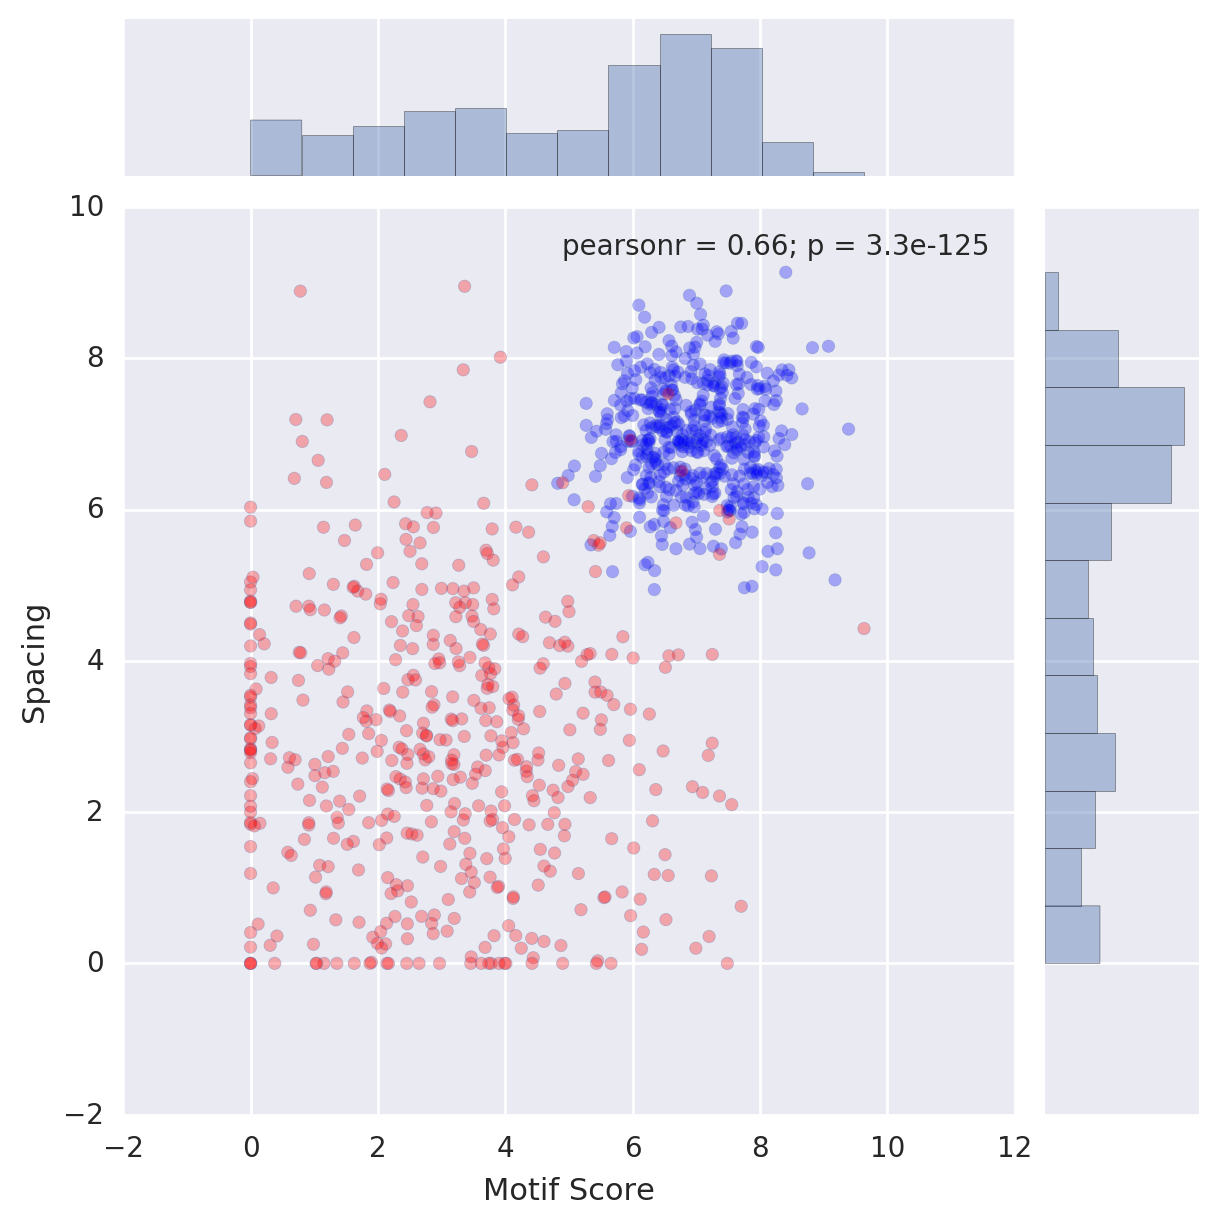

In [6]:
jg = sns.jointplot(
    x=distance_data[0], # score
    y=distance_data[1], # distance
    c= ['blue' if x == 1 else 'red' for x in distance_data[2]],
    alpha= 0.3,
)
jg.ax_joint.set_xlabel('Motif Score')
jg.ax_joint.set_ylabel('Spacing')

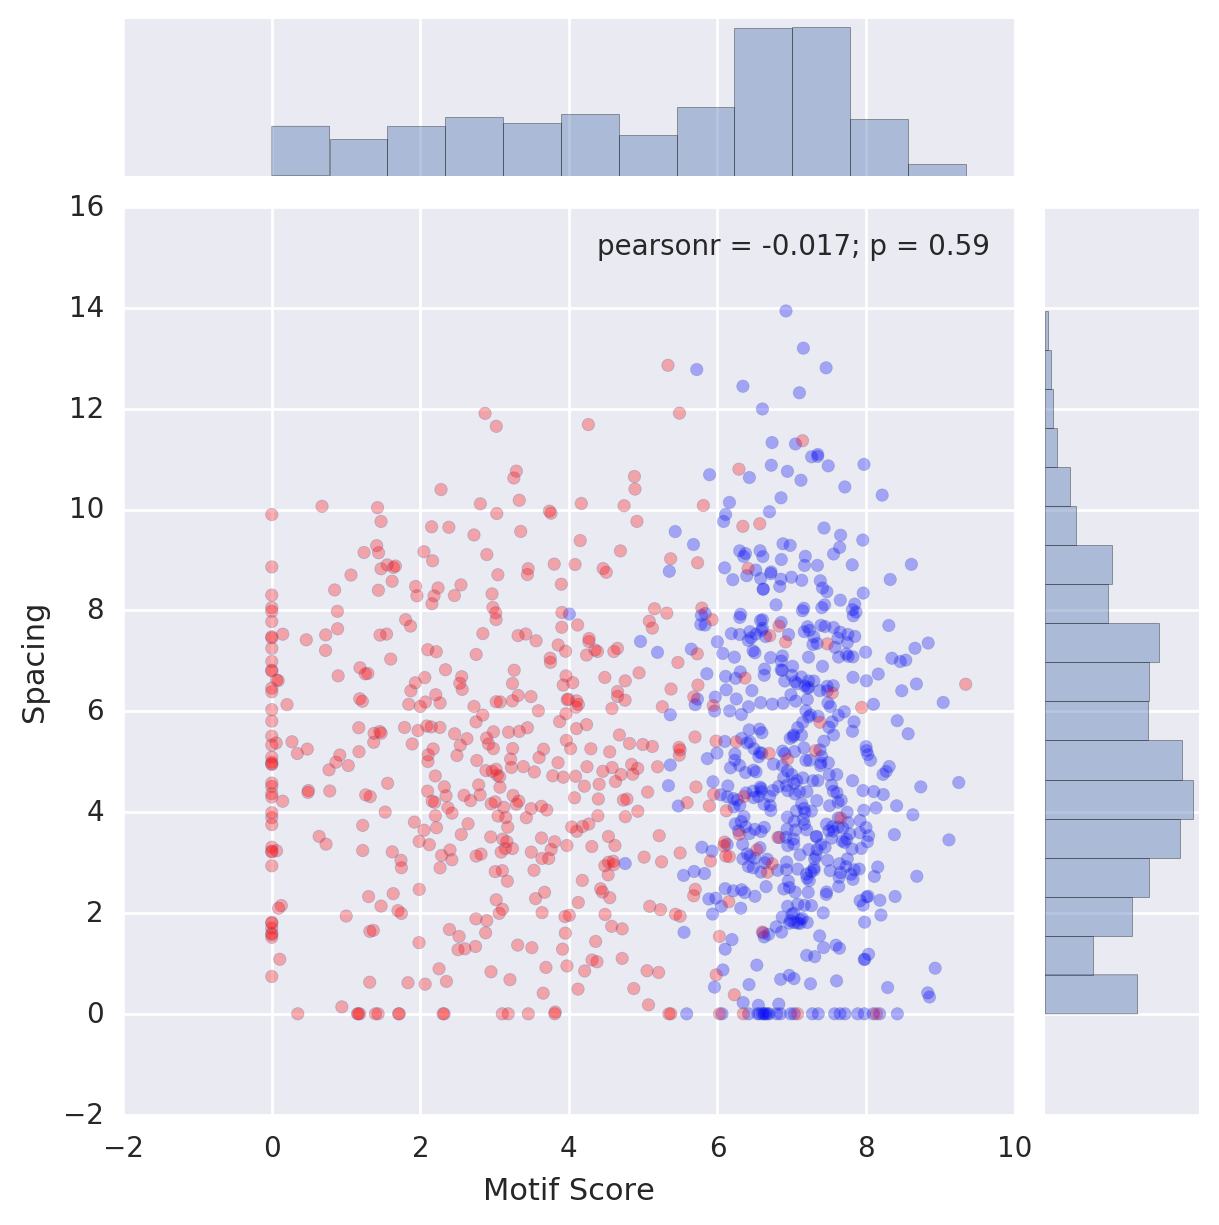

In [7]:
jg=sns.jointplot(
    x=nodistance_data[0], 
    y=nodistance_data[1],
    c= ['blue' if x == 1 else 'red' for x in nodistance_data[2]],
    alpha= 0.3,
)
jg.ax_joint.set_xlabel('Motif Score')
jg.ax_joint.set_ylabel('Spacing')

#### L2 Penalized

In [13]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

In [42]:
#Regularized cost function
def cost_function_L2(theta, X, y, c = 0.1):
    m = len(y)
    h = sigmoid(X.dot(theta))
    tmp = np.copy(theta)
    tmp[0] = 0 
    reg = (c/(2*m)) * np.sum(tmp**2)

    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg



#Regularized gradient function
def gradient_L2(theta, X, y, c = 0.1):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    tmp = np.copy(theta)
    tmp[0] = 0
    reg = (c/(2*m)) * np.sum(tmp**2)
    return ((1 / m) * X.T.dot(h - y)) + reg

#Optimal theta 
def logistic_regression_L2(X, y, theta, c=0.1):
    result = optimize.minimize(fun = cost_function_L2, x0 = theta, args = (X, y, c),
                         method = 'TNC', jac = gradient_L2)
    
    return result.x

#### L1 Regularization

In [15]:
#Regularized cost function
def cost_function_L1(theta, X, y, c = 0.1):
    m = len(y)
    h = sigmoid(X.dot(theta))
    tmp = np.copy(theta)
    tmp[0] = 0 
    reg = (c/m) * np.sum(abs(tmp))

    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg



#Regularized gradient function
def gradient_L1(theta, X, y, c = 0.1):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    tmp = np.copy(theta)
    tmp[0] = 0
    return ((1 / m) * X.T.dot(h - y))

#Optimal theta 
def logistic_regression_L1(X, y, theta, c=0.1):
    result = optimize.minimize(fun = cost_function_L1, x0 = theta, args = (X, y, c),
                         method = 'TNC', jac = gradient_L1)
    
    return result.x

#### No regularization

In [16]:
def gradient(theta, X, y):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    return ((1 / m) * X.T.dot(h - y))

def cost_function(theta, X, y):
    m = len(y)
    h = sigmoid(X.dot(theta))
    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h)))
def logistic_regression_noReg(X, y, theta):
    result = optimize.minimize(fun = cost_function, x0 = theta, args = (X, y),
                         method = 'TNC', jac = gradient)
    
    return result.x

#### No Gradient

In [17]:
def logistic_regression_NM(X, y, theta):
    result = optimize.minimize(fun = cost_function, x0 = theta, args = (X, y),
                         method = 'nelder-mead',)
    
    return result.x

## Read in PU1 Data

In [23]:
# read in motif scores
scores_pos_frame = pd.read_csv('./PU1_mergedPeaks_C57_scaled_200_motif_scores.tsv', sep='\t', index_col=0)
scores_neg_frame = pd.read_csv('./background_motif_scores.tsv', sep='\t', index_col=0)

# read in distances to PU.1 motif
distances_pos_frame = pd.read_csv('./PU1_mergedPeaks_C57_scaled_200_motif_distances.tsv', sep='\t', index_col=0)
distances_neg_frame = pd.read_csv('./background_motif_distances.tsv', sep='\t', index_col=0)

#### Check that Indices don't overlap

In [24]:
scores_neg_frame.index.intersection(scores_pos_frame.index)

Index([], dtype='object')

In [25]:
distances_neg_frame.index.intersection(distances_pos_frame.index)

Index([], dtype='object')

### combine data frames

In [26]:
scores_frame = pd.concat([scores_pos_frame, scores_neg_frame])
distances_frame = pd.concat([distances_pos_frame, distances_neg_frame])
labels = pd.Series(data = np.array([1 for x in range(scores_pos_frame.shape[0])] + \
                                   [0 for x in range(scores_neg_frame.shape[0])]),
                   index = scores_frame.index.values)

### standardize_scores

In [27]:
from sklearn import preprocessing

In [30]:
scores_train, scores_test, distances_train, distances_test, labels_train, labels_test = model_selection.train_test_split(
    scores_frame, 
    distances_frame,
    labels,
    test_size = 0.5, 
    random_state = 12
    )

## Logistic Regression

In [39]:
scaler = preprocessing.StandardScaler()
standardized_scores = pd.DataFrame(scaler.fit_transform(scores_train))
standardized_scores.columns = scores_train.columns.values
standardized_scores.index = scores_train.index.values
standardized_scores = standardized_scores[sorted(scores_train.columns.values)]

optTheta = logistic_regression_L2(standardized_scores, 
    labels_train, 
    theta=np.zeros((scores_frame.shape[1],1)),
    )

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [40]:
scaler = preprocessing.StandardScaler()
standardized_scores = pd.DataFrame(scaler.fit_transform(scores_test))
standardized_scores.columns = scores_test.columns.values
standardized_scores.index = scores_test.index.values
standardized_scores = standardized_scores[sorted(scores_test.columns.values)]
P = sigmoid(standardized_scores.dot(optTheta.T))

print("Test Accuracy ", metrics.accuracy_score(labels_test, [1 if x > 0.5 else 0 for x in P]) * 100 , '%')
print("Test ROC ", metrics.roc_auc_score(labels_test, P) * 100 , '%')
print("Test Precision ", metrics.precision_score(labels_test, [1 if x > 0.5 else 0 for x in P]) * 100 , '%')

Test Accuracy  85.1370281949 %
Test ROC  92.8448262452 %
Test Precision  84.6745839519 %


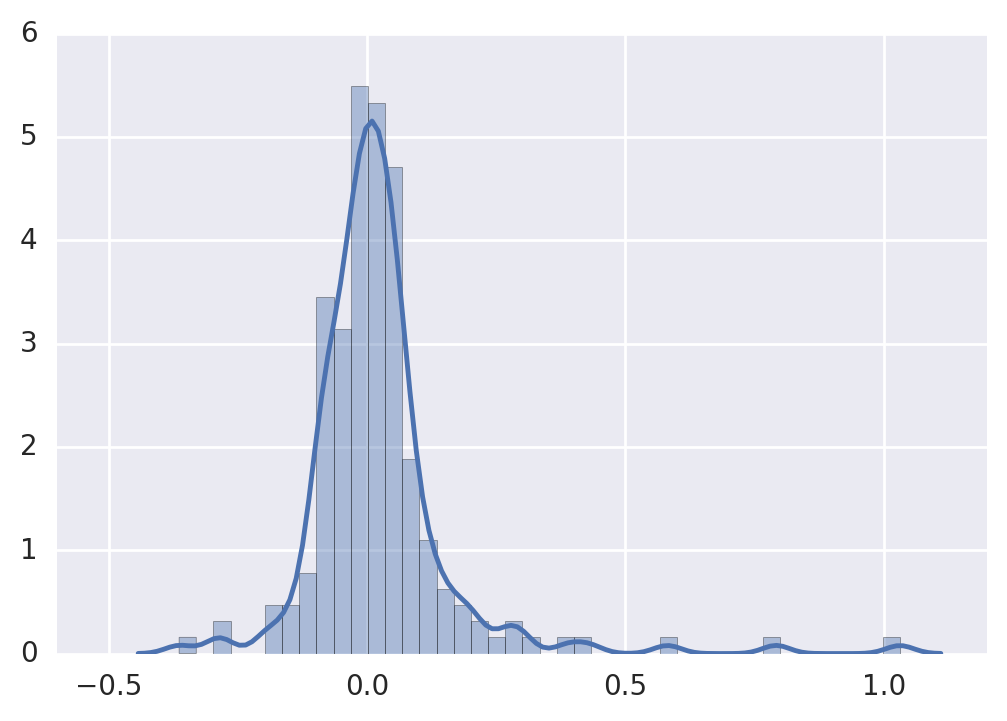

In [41]:
sns.distplot(optTheta)

## Define Distance Model

In [43]:
import sympy